# Machine Learning Project

## 1. Background
O cancro da mama é uma doença bastante comum e com grande impacto na saúde pública a nível mundial. 
A identificação antecipada é um fator determinante para o sucesso do tratamento e para o aumento da taxa de sobrevivência. Contudo, os métodos de diagnóstico tradicionais, como a mamografia, são muitas vezes invasivos, dispendiosos e dependem de equipamentos especializados.

Nos últimos anos, a análise de amostras de sangue tem surgido como uma alternativa promissora para a deteção precoce do cancro, oferecendo uma abordagem menos invasiva e mais acessível. Através da medição de parâmetros clínicos e bioquímicos, é possível identificar padrões associados à presença da doença.

## 2. Objective
O projeto tem como objetivo o desenvolvimento de pipelines de Machine Learning capazes de identificar, com base em dados clínicos recolhidos de amostras de sangue, se um indivíduo tem ou não cancro da mama.

# 3. Pratical Assignment

## 3.1 Data exploration
O trabalho recorre ao Breast Cancer Coimbra Dataset — um conjunto de dados com 116 amostras (64 de pacientes com cancro e 52 de controlos saudáveis), contendo dez variáveis relacionadas com características antropométricas e parâmetros sanguíneos.

In [1]:
import pandas as pd

data = pd.read_excel('dataR2.xlsx', usecols=["Age", "BMI", "Glucose", "Insulin", "HOMA", "Leptin", "Adiponectin", "Resistin", "MCP.1", "Classification"])

### Histogram
Um histograma permite-nos visualizar a distribuição de valores para cada variável e ajuda a ver a forma da distribuição, detetar valores discrepantes ou extremos, e comparar distribuições entre classes.

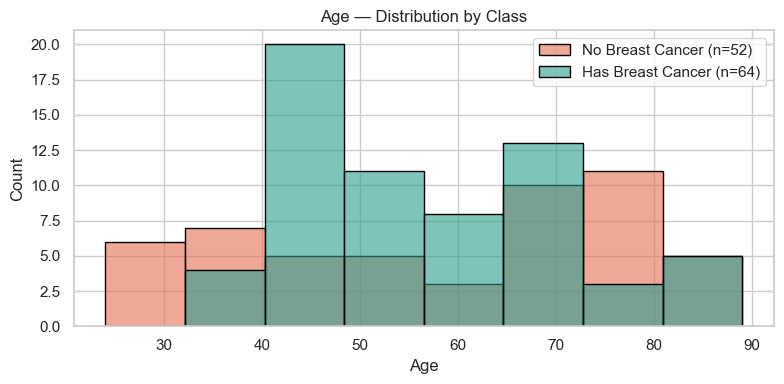

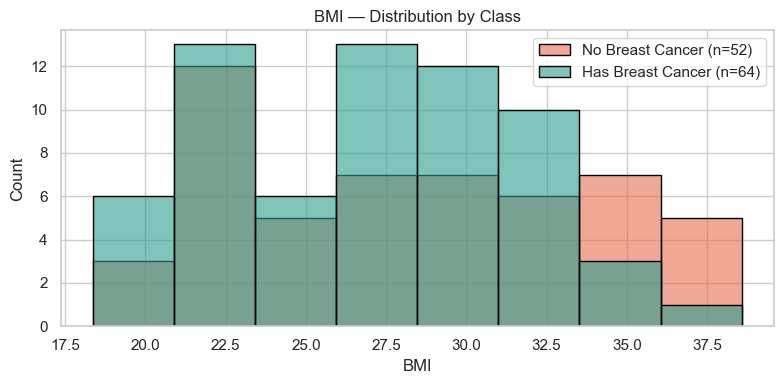

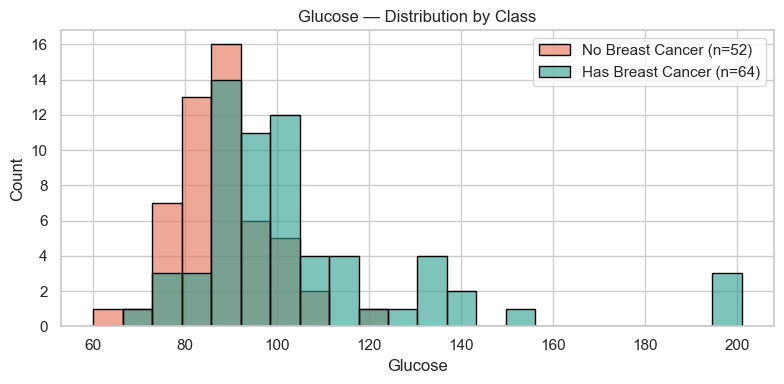

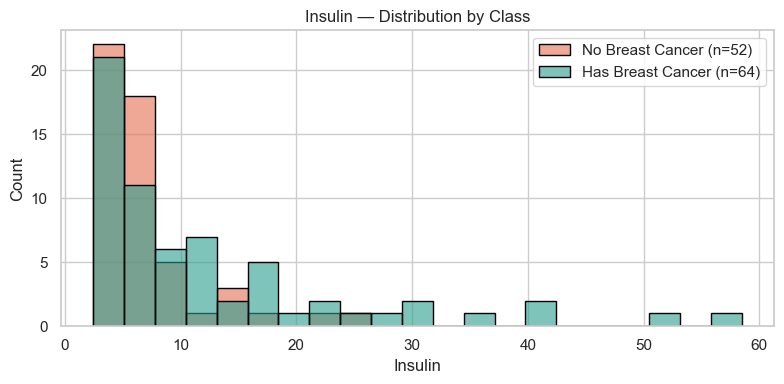

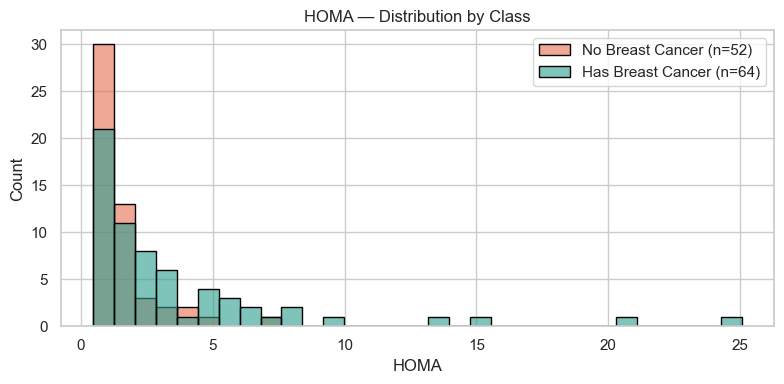

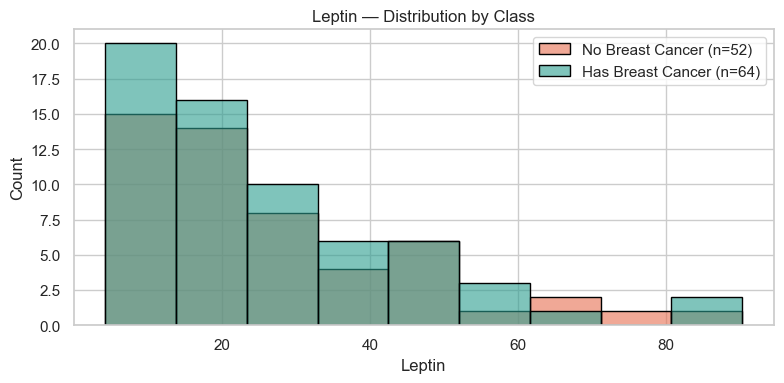

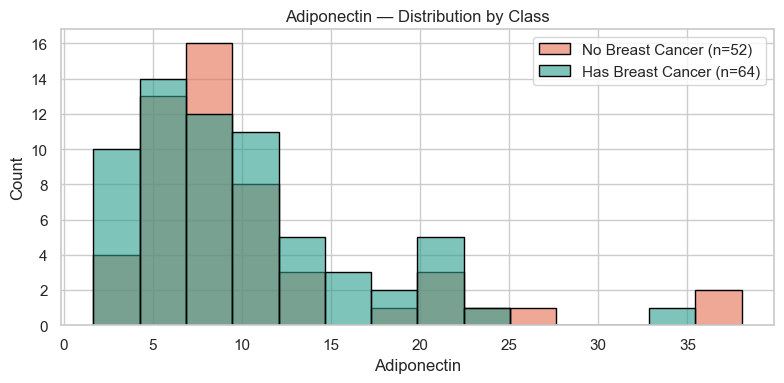

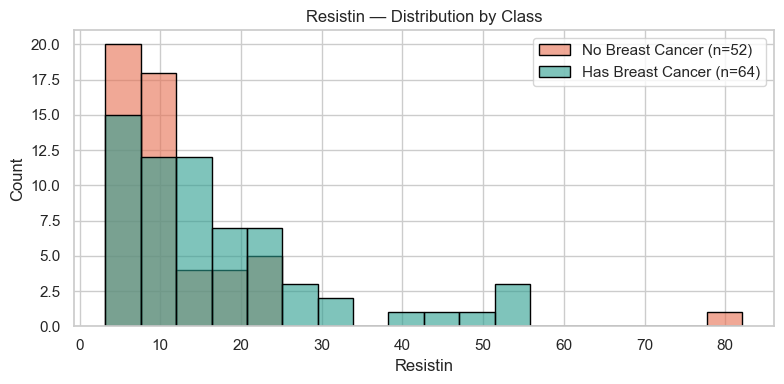

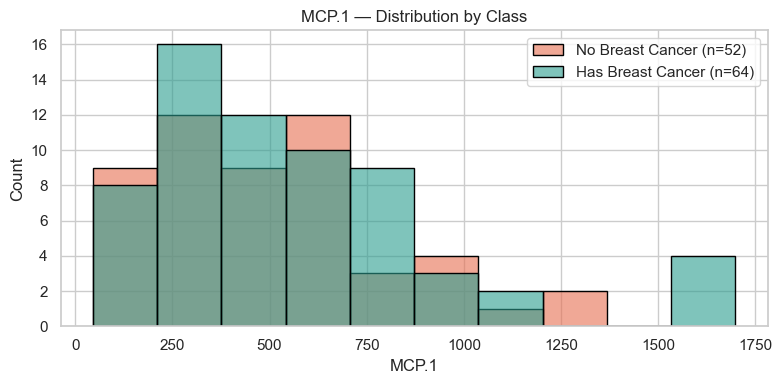

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="whitegrid", context="notebook")

columns = data.columns[:-1]  # Exclude "Classification"
palette = {1: "#e76f51", 2: "#2a9d8f"}
class_labels = {1: "No Breast Cancer", 2: "Has Breast Cancer"}

for col in columns:
    plt.figure(figsize=(8, 4))
    for cls in [1, 2]:
        # use common bins for both classes so the histograms are comparable
        bins = np.histogram_bin_edges(data[col].dropna(), bins='auto')
        sns.histplot(
            data=data[data["Classification"] == cls],
            x=col,
            bins=bins,
            label=f"{class_labels[cls]} (n={len(data[data['Classification']==cls])})",
            color=palette[cls],
            alpha=0.6,
            stat='count',
            edgecolor='black'
        )
    plt.title(f"{col} — Distribution by Class")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()


### Box Plots

In [3]:
import plotly.graph_objects as go

class_labels = {1: "No Breast Cancer", 2: "Has Breast Cancer"}

for column in columns:
    fig = go.Figure()
    for label in class_labels:
        fig.add_trace(go.Violin(
            y=data[data['Classification'] == label][column],
            name=class_labels[label],
            box_visible=True,
            meanline_visible=True,
            points='all'
        ))
    fig.update_layout(
        title=f'{column} by Classification',
        autosize=False,
        width=1000,
        height=500,
        font=dict(size=18, color="black")
    )
    fig.show()

## 3.2 Data partioning
O particonamento dos dados permite avaliar a capacidade de generalização dos modelos e evitar o fenómeno de overfitting.
Por isso, a separação entre conjuntos de treino, validação e teste é importante, de modo a garantir que o modelo é avaliado utilizando apenas dados que não foram vistos durante o treino.

Dessa forma, procedeu-se à divisão do conjunto de dados em subconjuntos de treino e de teste, de forma a avaliar o desempenho do modelo em dados não utilizados durante o treino. Foram testadas duas proporções de partição: 70% para treino e 30% para teste, e 60% para treino e 40% para teste.

O parâmetro "stratify=y" foi usado de modo a garantir que as proporções das classes (1 e 2) sejam mantidas tanto no treino como no teste.

In [4]:
from sklearn.model_selection import train_test_split

X = data.drop('Classification', axis=1)
y = data['Classification']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=1
)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=1
)



## 3.3 Feature Selection and Dimensionality Reduction

### Receiver Operator Characteristics (ROC) ###
O ROC tem como função saber que features são as mais discriminadoras entre os classificadores. Neste caso, refere quais features discriminam mais entre pacientes com cancro e pacientes saudáveis. 

Analisando os gráficos, a feature glucose apresenta ser a mais discriminadora, o que significa que é a característica que permite identificar os pacientes com uma maior precisão.

In [5]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Find the indexes where de class samples are located
ixHealthy = np.where(y_train == 1)[0]
ixCancer = np.where(y_train == 2)[0]

ixHasOrNot=np.concatenate((ixHealthy,ixCancer))
y=y_train.to_numpy()[ixHasOrNot]


roc_auc=np.zeros(columns.shape)
i=0
for f in columns: #Go along features
    fpr, tpr, _= roc_curve(y,X_train[f].to_numpy()[ixHasOrNot],pos_label=2)
    
    figR = go.Figure()
    figR.add_scatter(x=fpr, y=tpr,mode='lines+markers')
    figR.update_layout(autosize=False,width=700,height=700,title=dict(text=f))
    figR.update_xaxes(title_text="1-SP",range=[-0.01, 1.01])
    figR.update_yaxes(title_text="SS",range=[-0.01, 1.01])
    

    roc_auc[i] = auc(fpr, tpr)#Compute area under the ROC curve
    
    figR.add_annotation(x=0.5, y=0.5,
            text="AUC: "+str(roc_auc[i]),
            showarrow=False,
            yshift=10)
    figR.show()
    i=i+1

sortIx=np.flip(np.argsort(roc_auc))
print("Sorting accourding to ROC-AUC:")
for i in sortIx:
    print(columns[i]+"-->"+str(roc_auc[i]))

Sorting accourding to ROC-AUC:
Glucose-->0.7762345679012346
HOMA-->0.6635802469135802
Resistin-->0.6160493827160494
Insulin-->0.6108024691358025
Adiponectin-->0.5820987654320987
Age-->0.47777777777777775
MCP.1-->0.47530864197530864
Leptin-->0.4709876543209877
BMI-->0.3725308641975309


In [6]:
from scipy import stats
import numpy as np

X = X_train.to_numpy(dtype=float)

ixHealthy = (y_train == 1).to_numpy()
ixCancer = (y_train == 2).to_numpy()

fnames = X_train.columns

Hs = []

for i in range(X.shape[1]):
    st = stats.kruskal(X[ixHealthy, i].flatten(), X[ixCancer, i].flatten())
    Hs.append((fnames[i], st.statistic, st.pvalue))

Hs = sorted(Hs, key=lambda x: x[1], reverse=True)

print("Ranked features (Kruskal-Wallis):")
for f in Hs:
    print(f"{f[0]:15} --> H = {f[1]:.4f}, p = {f[2]:.4f}")


Ranked features (Kruskal-Wallis):
Glucose         --> H = 18.1080, p = 0.0000
HOMA            --> H = 6.3437, p = 0.0118
BMI             --> H = 3.8522, p = 0.0497
Resistin        --> H = 3.1928, p = 0.0740
Insulin         --> H = 2.9106, p = 0.0880
Adiponectin     --> H = 1.5979, p = 0.2062
Leptin          --> H = 0.1995, p = 0.6551
MCP.1           --> H = 0.1445, p = 0.7038
Age             --> H = 0.1172, p = 0.7321


### Kruskall-Wallis conclusion ###
O Kruskal–Wallis H test é um método estatístico não paramétrico utilizado para verificar se existem diferenças estatisticamente significativas entre as medianas de três ou mais grupos independentes. Embora o problema em análise seja binário, optou-se por aplicar este teste, uma vez que permite identificar variáveis com potencial discriminativo entre classes, contribuindo assim para a seleção das features mais relevantes para os classificadores.

Com base nos resultados obtidos, verificou-se que as variáveis Glucose e HOMA apresentam valores elevados de H e p-values<0.05, indicando diferenças significativas entre os grupos. Estas variáveis foram, por isso, consideradas particularmente relevantes para as etapas seguintes de seleção de features e redução de dimensionalidade.

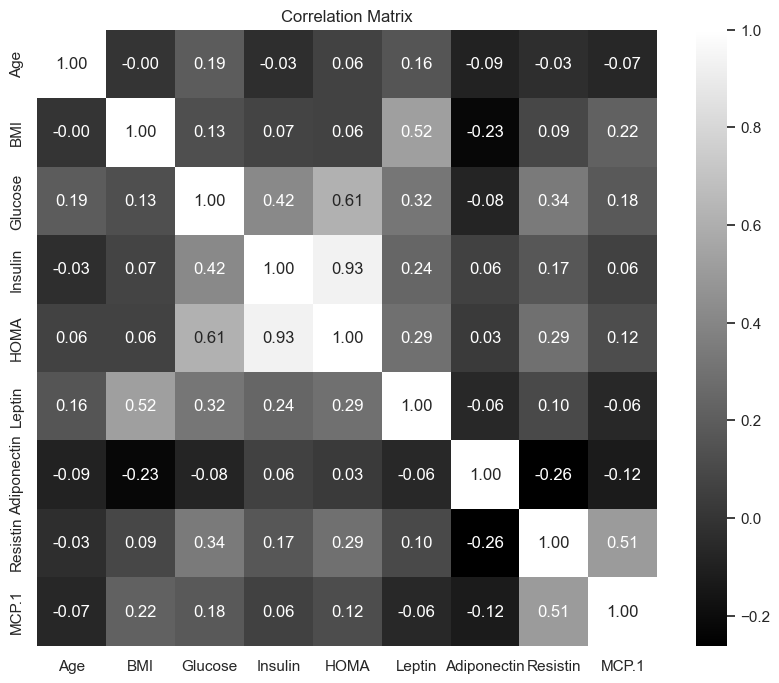

In [7]:
## Correlation matrix to see how the variables are correlated with each other.

plt.figure(figsize=(10, 8))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='gray', cbar=True)
plt.title('Correlation Matrix')
plt.show()

### Correlation Matrix conclusion ### 
A matriz de correlação foi analisada com o objetivo de identificar relações lineares fortes entre as variáveis e possíveis redundâncias de informação.
Verificou-se que as features HOMA e Insulin apresentam correlação elevada (|r| > 0.9), o que indica que fornecem informação semelhante.
Neste caso, optou-se por manter apenas a feature com maior relevância discriminativa, isto é, menor p-value do Kruskal-Wallis H test: HOMA.

### Data Normalization

In [8]:
# Data Normalization

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_2 = scaler.fit_transform(X_train_2)
X_test_scaled_2 = scaler.transform(X_test_2)

### Principal Component Analysis (PCA) ### 
Devido à matriz original conter uma grande variedade de variáveis, pode gerar redundâncias, só que, se eliminarmos demasiados componentes pode correr o risco de apagar informações importantes. Por essa razão é usado o PCA, que descobre quantos componentes devem ser mantidos para que não haja uma perca significativa de informação. Após a implementação, são devolvidas as percentagem de informação mantida de acordo com o Critério de Kaiser e o Teste de Scree. 

Verificou-se que, de acordo com o Critério de Kaiser, 91.14% da informação original é mantida e analisando o gráfico, 4 das 9 features são responsáveis por essa percentagem. Já o Teste de Scree indica que só 2.1% da informação é perdida usando 6 features. Concluindo, é possível manter a maior parte da informação só usando 4 features.

In [9]:
from sklearn.decomposition import PCA
import plotly.express as px

#PCA

X = X_train_scaled

pca = PCA()
pca.fit(X)

#PCA eigenvalues/Explained variance
print("PCA eigenvalues/Explained variance")
print(pca.explained_variance_)
print("Sum of eigenvalues="+str(np.sum(pca.explained_variance_)))
#PCA eigenvectors/Principal components
print("PCA eigenvectors/Principal components")
W=pca.components_.T
print(W)

fig = px.scatter(x=np.arange(1,10,1), y=pca.explained_variance_,
                 labels=dict(x="PC",y="Explained Variance"))
fig.add_hline(y=1,line_width=3, line_dash="dash", line_color="red")
fig.update_traces(marker_size=10)
fig.show()

#To know which indexes are > 1
kaiser_mask = pca.explained_variance_ > 1
kaiser_sum = np.sum(pca.explained_variance_[kaiser_mask] ** 2)
total_sum = np.sum(pca.explained_variance_ ** 2)

print("Variance (%) retained accourding to Kaiser: "+str((kaiser_sum/total_sum)*100))
print("Variance (%) retained accourding to Scree: "+str(np.sum(pca.explained_variance_[0:6]**2)/(np.sum(pca.explained_variance_**2))*100))

# 1-dimension PCA
pca2 = PCA(n_components=1)
X_1D = pca2.fit_transform(X)

print(np.shape(X_1D))

#Plot projected data
fig=px.scatter(x=X_1D[:, 0],y=np.zeros(np.shape(X_1D)[0]),color=y_train,labels=dict(x="PC1",y="",color="Cancer Patient"))
fig.update_traces(marker_size=8)
fig.update_xaxes
fig.show()

PCA eigenvalues/Explained variance
[2.82396544 1.59612809 1.40823034 1.0746661  0.81612775 0.59038836
 0.47211361 0.29754198 0.03333833]
Sum of eigenvalues=9.112499999999999
PCA eigenvectors/Principal components
[[ 0.07904712  0.02199785  0.34248444  0.78562066  0.30716373  0.33991077
  -0.18831711  0.1103082  -0.03538526]
 [ 0.21673187 -0.3860021   0.46455642 -0.40684084  0.0884333   0.29350032
   0.17866561  0.54346462  0.03820285]
 [ 0.45411467  0.0580891  -0.0040258   0.24953982  0.12034442 -0.4351596
   0.70183547  0.04717227 -0.17168078]
 [ 0.46298753  0.37483    -0.11376653 -0.14855212 -0.2184101   0.35206408
  -0.17967163  0.01689063 -0.63711473]
 [ 0.5240151   0.32231418 -0.12087171 -0.01102029 -0.13113104  0.16687592
  -0.05450535  0.01161833  0.7474233 ]
 [ 0.31509532 -0.06235211  0.57628871 -0.19174317  0.13400886 -0.33839291
  -0.32898794 -0.53557584 -0.02025702]
 [-0.09957407  0.47896595 -0.08888965 -0.27758069  0.78415742 -0.10229309
  -0.0898423   0.20558518 -0.00453596

Variance (%) retained accourding to Kaiser: 91.14495704261365
Variance (%) retained accourding to Scree: 97.91471412925833
(81, 1)


### Linear Discriminant Analysis (LDA)
Como o problema do dataset tem apenas duas classes, a projeção do LDA será apenas de 1 dimensão, independentemente do número de features.  

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

X = X_train_scaled_df.to_numpy()
y = y_train.to_numpy()

lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

transformed = lda.transform(X)

fig = px.scatter(
    x=transformed[:, 0], 
    y=np.zeros(transformed.shape[0]),
    color=y,
    labels=dict(x="LDA1", y="", color="Class")
)
fig.update_traces(marker_size=5)
fig.show()


## 3.4 Classification

Nesta etapa o objetivo é avaliar a capacidade dos modelos em distinguir entre indivíduos saudáveis e indivíduos com cancro, com base nas features disponíveis, previamente analisadas.

A avaliação do desempenho baseou-se em métricas de classificação como accuracy, precision, recall, F1-score. Dado o contexto clínico do problema, demos especial importância à métrica recall, de modo a procurar reduzir o número de FN, isto é, o modelo prever que o paciente não tem cancro, mas o paciente tem. É, por isso, especialmente importante minimizar o número de falsos negativos.

### Mahalanobis MDC and Euclidean MDC

In [11]:
#Euclidean (False) and Mahalaboris (True) MDC

def mdc(matrix, feat1, feat2, y, isMahalanobis, dataset_name):
    
    mdc_type = "Mahalanobis" if isMahalanobis else "Euclidean"

    # --- garante arrays numpy e índices posicionais ---
    y_arr = np.asarray(y).flatten()
    ixHealthy = np.where(y_arr == 1)[0]
    ixCancer  = np.where(y_arr == 2)[0]

    # extrai features
    f1H = matrix[feat1].to_numpy()[ixHealthy]
    f1C = matrix[feat1].to_numpy()[ixCancer]
    f2H = matrix[feat2].to_numpy()[ixHealthy]
    f2C = matrix[feat2].to_numpy()[ixCancer]

    # médias (column vectors 2x1)
    muH = np.array([[np.mean(f1H), np.mean(f2H)]]).T
    muC = np.array([[np.mean(f1C), np.mean(f2C)]]).T

    # covariâncias (para Mahalanobis)
    if isMahalanobis:
        CHealthy = np.cov(np.array([f1H, f2H]))
        CCancer  = np.cov(np.array([f1C, f2C]))
        C = (CHealthy + CCancer) / 2.0
        Ci = np.linalg.inv(C)
    else:
        Ci = None

   
    if not isMahalanobis:
        # Euclidean MDC
        W = (muC - muH)                 
        b = -0.5 * (W.T @ (muC + muH))  
        dx = (W.T @ np.column_stack([matrix[feat1], matrix[feat2]]).T + b).flatten()
    else:
        # Mahalanobis MDC
        W = Ci @ (muC - muH)
        b = -0.5 * (muC.T @ Ci @ muC - muH.T @ Ci @ muH)
        dx = (W.T @ np.column_stack([matrix[feat1], matrix[feat2]]).T + b).flatten()


    X1 = np.column_stack([f1H, f2H])
    X2 = np.column_stack([f1C, f2C])
    X = np.vstack([X1, X2])
    y_true = np.concatenate([y_arr[ixHealthy], y_arr[ixCancer]])

   
    y_pred = np.where(dx[ixHealthy.tolist() + ixCancer.tolist()] > 0, 2, 1)

    
    is_true_healthy = (y_true == 1)
    is_true_cancer  = (y_true == 2)
    is_pred_healthy = (y_pred == 1)
    is_pred_cancer  = (y_pred == 2)

    TP = np.sum(is_true_cancer & is_pred_cancer)
    TN = np.sum(is_true_healthy & is_pred_healthy)
    FP = np.sum(is_true_healthy & is_pred_cancer)
    FN = np.sum(is_true_cancer & is_pred_healthy)

    SS = TP / (TP + FN) 
    SP = TN / (TN + FP) 
    PR = TP / (TP + FP)  
    F1Score = 2 * (PR * SS) / (PR + SS)
    ACC = (TP + TN) / (TP + TN + FP + FN)
    
    print(mdc_type + " " + dataset_name)
    print("Sensitivity(%)="+str(SS*100))
    print("Specificity(%)="+str(SP*100))
    print("Precision(%)="+str(PR*100))
    print("F1Score(%)="+str(F1Score*100))
    print("Accuracy(%)="+str(ACC*100), "\n")

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=f1H, y=f2H, name='Healthy Patient', mode='markers'))
    fig.add_trace(go.Scatter(x=f1C, y=f2C, name='Cancer Patient', mode='markers'))
    fig.update_traces(marker=dict(size=10))

    ixFP = np.where(is_true_healthy & is_pred_cancer)[0]
    ixFN = np.where(is_true_cancer & is_pred_healthy)[0]

    fig.add_trace(go.Scatter(x=X[ixFP, 0], y=X[ixFP, 1], name='False Cancer',
                             mode='markers', marker_symbol="circle-open",
                             marker=dict(size=15, color="red", line=dict(width=3))))
    fig.add_trace(go.Scatter(x=X[ixFN, 0], y=X[ixFN, 1], name='False Healthy',
                             mode='markers', marker_symbol="circle-open",
                             marker=dict(size=15, color="blue", line=dict(width=3))))

    
    fig.add_trace(go.Scatter(x=[muH[0,0]], y=[muH[1,0]], name='Healthy mean',
                             mode='markers', marker=dict(size=20, symbol='x', color="green")))
    fig.add_trace(go.Scatter(x=[muC[0,0]], y=[muC[1,0]], name='Cancer mean',
                             mode='markers', marker=dict(size=20, symbol='x', color="yellow")))
    fig.add_trace(go.Scatter(x=[(muH[0,0]+muC[0,0])/2], y=[(muH[1,0]+muC[1,0])/2],
                             name='Mean of means', mode='markers',
                             marker=dict(size=20, symbol="circle-dot", color="purple")))
    fig.add_trace(go.Scatter(x=[muH[0,0], muC[0,0]], y=[muH[1,0], muC[1,0]],
                             mode='lines', line=dict(color="black", width=4), name='Inter mean segment'))

    # --- Hyperplane ---
    W_vec = W.flatten()
    b_scalar = float(b)
    x1_vals = np.linspace(np.min(X[:,0]) - 0.5, np.max(X[:,0]) + 0.5, 200)
    x2_vals = -(W_vec[0]/W_vec[1]) * x1_vals - (b_scalar / W_vec[1])

    fig.add_trace(go.Scatter(x=x1_vals, y=x2_vals, mode='lines',
                             line=dict(dash='dash', color="gray", width=4),
                             name='Hyperplane'))

    fig.update_xaxes(title_text=feat1)
    fig.update_yaxes(title_text=feat2)
    fig.update_layout(width=900, height=800)
    
    
        
    fig.update_layout(title=f"MDC - {mdc_type} | {dataset_name}")
    fig.show()

print("Glucose and Insulin: \n")
mdc(X_train, 'Glucose', 'Insulin', y_train, False, "Train 1 (70/30)")
mdc(X_train, 'Glucose', 'Insulin', y_train, True, "Train 1 (70/30)")
mdc(X_test, 'Glucose', 'Insulin', y_test, False, "Test 1 (70/30)")
mdc(X_test, 'Glucose', 'Insulin', y_test, True, "Test 1 (70/30)")
mdc(X_train_2, 'Glucose', 'Insulin', y_train_2, False, "Train 2 (60/40)")
mdc(X_train_2, 'Glucose', 'Insulin', y_train_2, True, "Train 2 (60/40)")
mdc(X_test_2, 'Glucose', 'Insulin', y_test_2, False, "Test 2 (60/40)")
mdc(X_test_2, 'Glucose', 'Insulin', y_test_2, True, "Test 2 (60/40)")

Glucose and Insulin: 

Euclidean Train 1 (70/30)
Sensitivity(%)=55.55555555555556
Specificity(%)=83.33333333333334
Precision(%)=80.64516129032258
F1Score(%)=65.78947368421053
Accuracy(%)=67.90123456790124 



C:\Users\jpsrl\AppData\Local\Temp\ipykernel_37456\1457839610.py:104: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



Mahalanobis Train 1 (70/30)
Sensitivity(%)=62.22222222222222
Specificity(%)=83.33333333333334
Precision(%)=82.35294117647058
F1Score(%)=70.88607594936708
Accuracy(%)=71.60493827160494 



Euclidean Test 1 (70/30)
Sensitivity(%)=57.89473684210527
Specificity(%)=81.25
Precision(%)=78.57142857142857
F1Score(%)=66.66666666666667
Accuracy(%)=68.57142857142857 



Mahalanobis Test 1 (70/30)
Sensitivity(%)=42.10526315789473
Specificity(%)=93.75
Precision(%)=88.88888888888889
F1Score(%)=57.14285714285714
Accuracy(%)=65.71428571428571 



Euclidean Train 2 (60/40)
Sensitivity(%)=57.89473684210527
Specificity(%)=80.64516129032258
Precision(%)=78.57142857142857
F1Score(%)=66.66666666666667
Accuracy(%)=68.11594202898551 



Mahalanobis Train 2 (60/40)
Sensitivity(%)=55.26315789473685
Specificity(%)=80.64516129032258
Precision(%)=77.77777777777779
F1Score(%)=64.61538461538461
Accuracy(%)=66.66666666666666 



Euclidean Test 2 (60/40)
Sensitivity(%)=69.23076923076923
Specificity(%)=90.47619047619048
Precision(%)=90.0
F1Score(%)=78.26086956521738
Accuracy(%)=78.72340425531915 



Mahalanobis Test 2 (60/40)
Sensitivity(%)=53.84615384615385
Specificity(%)=95.23809523809523
Precision(%)=93.33333333333333
F1Score(%)=68.29268292682926
Accuracy(%)=72.3404255319149 



Efetuou-se vários experimentos entre as 6 melhores features para saber qual par de features consegue distinguir os pacientes com as distância dos seus vetores e concluiu-se que o melhor par de features é a Glucose e o Insulin. 

Analisando os gráficos com estas características, conseguiu-se ver que gerou melhores resultados quando 60% dos dados são usados para treino e os restantes, 40%, para teste. Para além disso, os testes mostraram melhores resultados quando é usado Euclidean MDC. 

### FISHER LDA

In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


X_train = X_train_scaled        
X_test = X_test_scaled
y_train_arr = y_train.values
y_test_arr = y_test.values


insulin_idx = list(X_train_scaled_df.columns).index('Insulin')

X_train = X_train[:, [i for i in range(X_train.shape[1]) if i != insulin_idx]]
X_test = X_test[:, [i for i in range(X_test.shape[1]) if i != insulin_idx]]

    
classes = np.unique(y_train_arr)

c1, c2 = classes[0], classes[1]

# Compute class means
m1 = X_train[y_train_arr == c1].mean(axis=0)
m2 = X_train[y_train_arr == c2].mean(axis=0)

# Within-class scatter matrix
Sw = np.zeros((X_train.shape[1], X_train.shape[1]))
for c, m in ((c1, m1), (c2, m2)):
    Xc = X_train[y_train_arr == c] - m
    Sw += Xc.T @ Xc

w = np.linalg.pinv(Sw) @ (m2 - m1)
w = w / np.linalg.norm(w)

proj_train = X_train @ w
proj_test = X_test @ w

t1 = proj_train[y_train_arr == c1].mean()
t2 = proj_train[y_train_arr == c2].mean()
b = -0.5 * (w.T @ (m1 + m2))
pred_train = np.where((X_train @ w + b) > 0, c2, c1)
pred_test = np.where((X_test @ w + b) > 0, c2, c1)

print("Train accuracy:", accuracy_score(y_train_arr, pred_train))
print("Train confusion matrix:\n", confusion_matrix(y_train_arr, pred_train))
print(classification_report(y_train_arr, pred_train, digits=4))

print("Test accuracy:", accuracy_score(y_test_arr, pred_test))
print("Test confusion matrix:\n", confusion_matrix(y_test_arr, pred_test))
print(classification_report(y_test_arr, pred_test, digits=4))

print("\nTest confusion matrix (counts):")

from sklearn.metrics import confusion_matrix as _confusion_matrix
cm = _confusion_matrix(y_test_arr, pred_test, labels=[c1, c2])
cm_test_df = pd.DataFrame(cm,index=[f"True: {class_labels[c1]}", f"True: {class_labels[c2]}"],columns=[f"Pred: {class_labels[c1]}", f"Pred: {class_labels[c2]}"])
print(cm_test_df)

Train accuracy: 0.7530864197530864
Train confusion matrix:
 [[30  6]
 [14 31]]
              precision    recall  f1-score   support

           1     0.6818    0.8333    0.7500        36
           2     0.8378    0.6889    0.7561        45

    accuracy                         0.7531        81
   macro avg     0.7598    0.7611    0.7530        81
weighted avg     0.7685    0.7531    0.7534        81

Test accuracy: 0.6571428571428571
Test confusion matrix:
 [[ 8  8]
 [ 4 15]]
              precision    recall  f1-score   support

           1     0.6667    0.5000    0.5714        16
           2     0.6522    0.7895    0.7143        19

    accuracy                         0.6571        35
   macro avg     0.6594    0.6447    0.6429        35
weighted avg     0.6588    0.6571    0.6490        35


Test confusion matrix (counts):
                         Pred: No Breast Cancer  Pred: Has Breast Cancer
True: No Breast Cancer                        8                        8
True: Has B

In [13]:
# Fisher LDA 70/30 with top 4 features

top_features = [f[0] for f in Hs[:4]]
print("Top 4 features selecionadas:", top_features)


X_train_sel = X_train_scaled_df[top_features].to_numpy()


X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train_scaled_df.columns)
X_test_sel = X_test_scaled_df[top_features].to_numpy()

y_train_arr = y_train.values
y_test_arr = y_test.values

classes = np.unique(y_train_arr)
c1, c2 = classes[0], classes[1]

m1 = X_train_sel[y_train_arr == c1].mean(axis=0)
m2 = X_train_sel[y_train_arr == c2].mean(axis=0)

Sw = np.zeros((X_train_sel.shape[1], X_train_sel.shape[1]))
for c, m in ((c1, m1), (c2, m2)):
    Xc = X_train_sel[y_train_arr == c] - m
    Sw += Xc.T @ Xc

w = np.linalg.pinv(Sw) @ (m2 - m1)
b = -0.5 * (w.T @ (m1 + m2))

pred_train = np.where((X_train_sel @ w + b) > 0, c2, c1)
pred_test  = np.where((X_test_sel @ w + b) > 0, c2, c1)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("\nTrain accuracy:", accuracy_score(y_train_arr, pred_train))
print("Train classification report:\n", classification_report(y_train_arr, pred_train, digits=4))
print("\nTest accuracy:", accuracy_score(y_test_arr, pred_test))
print("Test classification report:\n", classification_report(y_test_arr, pred_test, digits=4))

# Simple confusion matrices as labeled DataFrame (counts)
cm_train = confusion_matrix(y_train_arr, pred_train, labels=[c1, c2])
cm_test  = confusion_matrix(y_test_arr,  pred_test,  labels=[c1, c2])

cm_train_df = pd.DataFrame(cm_train,
                           index=[f"True: {class_labels[c1]}", f"True: {class_labels[c2]}"],
                           columns=[f"Pred: {class_labels[c1]}", f"Pred: {class_labels[c2]}"])
cm_test_df = pd.DataFrame(cm_test,
                          index=[f"True: {class_labels[c1]}", f"True: {class_labels[c2]}"],
                          columns=[f"Pred: {class_labels[c1]}", f"Pred: {class_labels[c2]}"])


print("\nTest confusion matrix (counts):")
print(cm_test_df)

x_idx, y_idx = 0, 1
x_min, x_max = X_test_sel[:, x_idx].min(), X_test_sel[:, x_idx].max()
x_vals = np.linspace(x_min, x_max, 200)

if w[y_idx] != 0:
    y_vals = -(w[x_idx] * x_vals + b) / w[y_idx]
else:
    y_vals = np.zeros_like(x_vals)

ix_c1 = np.where(y_test_arr == c1)[0]
ix_c2 = np.where(y_test_arr == c2)[0]

Top 4 features selecionadas: ['Glucose', 'HOMA', 'BMI', 'Resistin']

Train accuracy: 0.7160493827160493
Train classification report:
               precision    recall  f1-score   support

           1     0.6383    0.8333    0.7229        36
           2     0.8235    0.6222    0.7089        45

    accuracy                         0.7160        81
   macro avg     0.7309    0.7278    0.7159        81
weighted avg     0.7412    0.7160    0.7151        81


Test accuracy: 0.6571428571428571
Test classification report:
               precision    recall  f1-score   support

           1     0.6429    0.5625    0.6000        16
           2     0.6667    0.7368    0.7000        19

    accuracy                         0.6571        35
   macro avg     0.6548    0.6497    0.6500        35
weighted avg     0.6558    0.6571    0.6543        35


Test confusion matrix (counts):
                         Pred: No Breast Cancer  Pred: Has Breast Cancer
True: No Breast Cancer                    

In [14]:
# Fisher LDA 60/40 with top 4 features

top_features = [f[0] for f in Hs[:4]]
print("Top 4 features selecionadas:", top_features)

# Convert the scaled arrays for the 60/40 split back to DataFrames so we can select columns by name
X_train_scaled_df_2 = pd.DataFrame(X_train_scaled_2, columns=X_train_scaled_df.columns)
X_test_scaled_df_2  = pd.DataFrame(X_test_scaled_2,  columns=X_train_scaled_df.columns)

X_train_sel = X_train_scaled_df_2[top_features].to_numpy()
X_test_sel  = X_test_scaled_df_2[top_features].to_numpy()

# Use the corresponding labels for the 60/40 split
y_train_arr = y_train_2.values
y_test_arr  = y_test_2.values

classes = np.unique(y_train_arr)
c1, c2 = classes[0], classes[1]

m1 = X_train_sel[y_train_arr == c1].mean(axis=0)
m2 = X_train_sel[y_train_arr == c2].mean(axis=0)

Sw = np.zeros((X_train_sel.shape[1], X_train_sel.shape[1]))
for c, m in ((c1, m1), (c2, m2)):
    Xc = X_train_sel[y_train_arr == c] - m
    Sw += Xc.T @ Xc

w = np.linalg.pinv(Sw) @ (m2 - m1)
b = -0.5 * (w.T @ (m1 + m2))

pred_train = np.where((X_train_sel @ w + b) > 0, c2, c1)
pred_test  = np.where((X_test_sel  @ w + b) > 0, c2, c1)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
acc_train = accuracy_score(y_train_arr, pred_train)
acc_test  = accuracy_score(y_test_arr, pred_test)

cm_train = confusion_matrix(y_train_arr, pred_train, labels=[c1, c2])
cm_test  = confusion_matrix(y_test_arr,  pred_test,  labels=[c1, c2])

cm_train_df = pd.DataFrame(cm_train,
                           index=[f"True: {class_labels[c1]}", f"True: {class_labels[c2]}"],
                           columns=[f"Pred: {class_labels[c1]}", f"Pred: {class_labels[c2]}"])
cm_test_df = pd.DataFrame(cm_test,
                          index=[f"True: {class_labels[c1]}", f"True: {class_labels[c2]}"],
                          columns=[f"Pred: {class_labels[c1]}", f"Pred: {class_labels[c2]}"])


print("\nTrain accuracy:", accuracy_score(y_train_arr, pred_train))
print("Train classification report:\n", classification_report(y_train_arr, pred_train, digits=4))
print("\nTest accuracy:", accuracy_score(y_test_arr, pred_test))
print("Test classification report:\n", classification_report(y_test_arr, pred_test, digits=4))

# Confusion matrices (counts) com labels formatados
cm_train = confusion_matrix(y_train_arr, pred_train, labels=[c1, c2])
cm_test  = confusion_matrix(y_test_arr,  pred_test,  labels=[c1, c2])

cm_train_df = pd.DataFrame(cm_train,
                           index=[f"True: {class_labels[c1]}", f"True: {class_labels[c2]}"],
                           columns=[f"Pred: {class_labels[c1]}", f"Pred: {class_labels[c2]}"])
cm_test_df = pd.DataFrame(cm_test,
                          index=[f"True: {class_labels[c1]}", f"True: {class_labels[c2]}"],
                          columns=[f"Pred: {class_labels[c1]}", f"Pred: {class_labels[c2]}"])


print("\nTest confusion matrix (counts):")
print(cm_test_df)

x_idx, y_idx = 0, 1
x_min, x_max = X_test_sel[:, x_idx].min(), X_test_sel[:, x_idx].max()
x_vals = np.linspace(x_min, x_max, 200)

if w[y_idx] != 0:
    y_vals = -(w[x_idx] * x_vals + b) / w[y_idx]
else:
    y_vals = np.zeros_like(x_vals)

ix_c1 = np.where(y_test_arr == c1)[0]
ix_c2 = np.where(y_test_arr == c2)[0]

Top 4 features selecionadas: ['Glucose', 'HOMA', 'BMI', 'Resistin']

Train accuracy: 0.7536231884057971
Train classification report:
               precision    recall  f1-score   support

           1     0.6842    0.8387    0.7536        31
           2     0.8387    0.6842    0.7536        38

    accuracy                         0.7536        69
   macro avg     0.7615    0.7615    0.7536        69
weighted avg     0.7693    0.7536    0.7536        69


Test accuracy: 0.6595744680851063
Test classification report:
               precision    recall  f1-score   support

           1     0.6087    0.6667    0.6364        21
           2     0.7083    0.6538    0.6800        26

    accuracy                         0.6596        47
   macro avg     0.6585    0.6603    0.6582        47
weighted avg     0.6638    0.6596    0.6605        47


Test confusion matrix (counts):
                         Pred: No Breast Cancer  Pred: Has Breast Cancer
True: No Breast Cancer                    

In [15]:
# Fisher LDA 60/40 with top 6 features

top_features = [f[0] for f in Hs[:6]]
print("Top 6 features selecionadas:", top_features)

# Convert the scaled arrays for the 60/40 split back to DataFrames so we can select columns by name
X_train_scaled_df_2 = pd.DataFrame(X_train_scaled_2, columns=X_train_scaled_df.columns)
X_test_scaled_df_2  = pd.DataFrame(X_test_scaled_2,  columns=X_train_scaled_df.columns)

X_train_sel = X_train_scaled_df_2[top_features].to_numpy()
X_test_sel  = X_test_scaled_df_2[top_features].to_numpy()

# Use the corresponding labels for the 60/40 split
y_train_arr = y_train_2.values
y_test_arr  = y_test_2.values

classes = np.unique(y_train_arr)
c1, c2 = classes[0], classes[1]

m1 = X_train_sel[y_train_arr == c1].mean(axis=0)
m2 = X_train_sel[y_train_arr == c2].mean(axis=0)

Sw = np.zeros((X_train_sel.shape[1], X_train_sel.shape[1]))
for c, m in ((c1, m1), (c2, m2)):
    Xc = X_train_sel[y_train_arr == c] - m
    Sw += Xc.T @ Xc

w = np.linalg.pinv(Sw) @ (m2 - m1)
b = -0.5 * (w.T @ (m1 + m2))

pred_train = np.where((X_train_sel @ w + b) > 0, c2, c1)
pred_test  = np.where((X_test_sel  @ w + b) > 0, c2, c1)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("\nTrain accuracy:", accuracy_score(y_train_arr, pred_train))
print(classification_report(y_train_arr, pred_train, digits=4))
print("Test accuracy:", accuracy_score(y_test_arr, pred_test))
print(classification_report(y_test_arr, pred_test, digits=4))

cm_train = confusion_matrix(y_train_arr, pred_train, labels=[c1, c2])
cm_test  = confusion_matrix(y_test_arr,  pred_test,  labels=[c1, c2])

cm_train_df = pd.DataFrame(cm_train,
                           index=[f"True: {class_labels[c1]}", f"True: {class_labels[c2]}"],
                           columns=[f"Pred: {class_labels[c1]}", f"Pred: {class_labels[c2]}"])
cm_test_df = pd.DataFrame(cm_test,
                          index=[f"True: {class_labels[c1]}", f"True: {class_labels[c2]}"],
                          columns=[f"Pred: {class_labels[c1]}", f"Pred: {class_labels[c2]}"])

print("\nTest confusion matrix (counts):")
print(cm_test_df)

x_idx, y_idx = 0, 1
x_min, x_max = X_test_sel[:, x_idx].min(), X_test_sel[:, x_idx].max()
x_vals = np.linspace(x_min, x_max, 200)

if w[y_idx] != 0:
    y_vals = -(w[x_idx] * x_vals + b) / w[y_idx]
else:
    y_vals = np.zeros_like(x_vals)

ix_c1 = np.where(y_test_arr == c1)[0]
ix_c2 = np.where(y_test_arr == c2)[0]

Top 6 features selecionadas: ['Glucose', 'HOMA', 'BMI', 'Resistin', 'Insulin', 'Adiponectin']

Train accuracy: 0.7536231884057971
              precision    recall  f1-score   support

           1     0.6842    0.8387    0.7536        31
           2     0.8387    0.6842    0.7536        38

    accuracy                         0.7536        69
   macro avg     0.7615    0.7615    0.7536        69
weighted avg     0.7693    0.7536    0.7536        69

Test accuracy: 0.723404255319149
              precision    recall  f1-score   support

           1     0.7000    0.6667    0.6829        21
           2     0.7407    0.7692    0.7547        26

    accuracy                         0.7234        47
   macro avg     0.7204    0.7179    0.7188        47
weighted avg     0.7225    0.7234    0.7226        47


Test confusion matrix (counts):
                         Pred: No Breast Cancer  Pred: Has Breast Cancer
True: No Breast Cancer                       14                        7
True

Embora a análise de componentes principais (PCA) tenha mostrado que é possível reter a maior parte da variabilidade dos dados utilizando apenas as quatro variáveis mais discriminativas, decidiu-se testar o classificador Fisher LDA com diferentes conjuntos de features.

Os resultados obtidos indicam uma ligeira melhoria ao aumentar o número de variáveis consideradas:

- Com 4 features (60% treino / 40% teste): Recall = 66.0%, F1-Score = 65.9%

- Com 6 features (60% treino / 40% teste): Recall = 71.8%, F1-Score = 72.3%

Estes resultados mostram que a inclusão de mais variáveis aumentou a capacidade do modelo em identificar corretamente os casos positivos (pessoas com cancro), sem comprometer a consistência global do modelo.

Dado o contexto clínico, o recall assume particular importância, uma vez que corresponde à proporção de doentes corretamente identificados. Assim, maximizar o recall é crucial para minimizar falsos negativos, isto é, situações em que o modelo classifica incorretamente uma pessoa com cancro como saudável — o tipo de erro mais grave neste cenário.


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

# Prepare data
X_sel = X_train_scaled_df[top_features].to_numpy()
y = y_train.to_numpy()

# For consistent labeling
classes_all = np.unique(y)
c1, c2 = classes_all[0], classes_all[1]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

results = []
confusion_matrices = []

for fold, (train_index, test_index) in enumerate(skf.split(X_sel, y), 1):
    X_train_fold, X_test_fold = X_sel[train_index], X_sel[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # compute Fisher LDA direction on the fold
    classes = np.unique(y_train_fold)
    cc1, cc2 = classes[0], classes[1]

    m1 = X_train_fold[y_train_fold == cc1].mean(axis=0)
    m2 = X_train_fold[y_train_fold == cc2].mean(axis=0)

    Sw = np.zeros((X_train_fold.shape[1], X_train_fold.shape[1]))
    for c, m in ((cc1, m1), (cc2, m2)):
        Xc = X_train_fold[y_train_fold == c] - m
        Sw += Xc.T @ Xc

    w = np.linalg.pinv(Sw) @ (m2 - m1)
    b = -0.5 * (w.T @ (m1 + m2))

    pred_train_fold = np.where((X_train_fold @ w + b) > 0, cc2, cc1)
    pred_test_fold  = np.where((X_test_fold  @ w + b) > 0, cc2, cc1)

    acc = accuracy_score(y_test_fold, pred_test_fold)
    prec = precision_score(y_test_fold, pred_test_fold, pos_label=cc2)
    rec = recall_score(y_test_fold, pred_test_fold, pos_label=cc2)
    f1 = f1_score(y_test_fold, pred_test_fold, pos_label=cc2)

    cm = confusion_matrix(y_test_fold, pred_test_fold, labels=[c1, c2])
    tn, fp, fn, tp = cm.ravel()

    print(f"\nFold {fold}:")
    print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1-Score: {f1:.3f}")
    print("Confusion Matrix:")
    print(pd.DataFrame(cm, index=[f"True {c1}", f"True {c2}"], columns=[f"Pred {c1}", f"Pred {c2}"]))
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

    results.append([fold, acc, prec, rec, f1, tn, fp, fn, tp])
    confusion_matrices.append(cm)

results_df = pd.DataFrame(results, columns=['Fold', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'TN', 'FP', 'FN', 'TP'])
print("\nFold metrics mean:")
print(results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].mean().round(3))

# --- Average confusion matrix across folds ---
cms = np.array(confusion_matrices)
avg_cm = cms.mean(axis=0)
sum_cm = cms.sum(axis=0).astype(int)

# Normalise average by true-class (rows) to get average per-class rates
row_sums = avg_cm.sum(axis=1, keepdims=True)
avg_cm_norm = np.divide(avg_cm, row_sums, out=np.zeros_like(avg_cm), where=row_sums!=0)

idx = [f"True: {class_labels[c1]}", f"True: {class_labels[c2]}"]
cols = [f"Pred: {class_labels[c1]}", f"Pred: {class_labels[c2]}"]

print("\nAverage confusion matrix (counts, averaged across folds):")
print(pd.DataFrame(np.round(avg_cm, 2), index=idx, columns=cols))

print("\nSummed confusion matrix (counts, summed across folds):")
print(pd.DataFrame(sum_cm, index=idx, columns=cols))



Fold 1:
Accuracy: 0.706 | Precision: 1.000 | Recall: 0.444 | F1-Score: 0.615
Confusion Matrix:
        Pred 1  Pred 2
True 1       8       0
True 2       5       4
TN=8, FP=0, FN=5, TP=4

Fold 2:
Accuracy: 0.812 | Precision: 0.800 | Recall: 0.889 | F1-Score: 0.842
Confusion Matrix:
        Pred 1  Pred 2
True 1       5       2
True 2       1       8
TN=5, FP=2, FN=1, TP=8

Fold 3:
Accuracy: 0.688 | Precision: 0.833 | Recall: 0.556 | F1-Score: 0.667
Confusion Matrix:
        Pred 1  Pred 2
True 1       6       1
True 2       4       5
TN=6, FP=1, FN=4, TP=5

Fold 4:
Accuracy: 0.688 | Precision: 0.700 | Recall: 0.778 | F1-Score: 0.737
Confusion Matrix:
        Pred 1  Pred 2
True 1       4       3
True 2       2       7
TN=4, FP=3, FN=2, TP=7

Fold 5:
Accuracy: 0.688 | Precision: 0.750 | Recall: 0.667 | F1-Score: 0.706
Confusion Matrix:
        Pred 1  Pred 2
True 1       5       2
True 2       3       6
TN=5, FP=2, FN=3, TP=6

Fold metrics mean:
Accuracy     0.716
Precision    0.817
Re

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

# Prepare data
X_sel = X_train_scaled_df[top_features].to_numpy()
y = y_train.to_numpy()

# For consistent labeling
classes_all = np.unique(y)
c1, c2 = classes_all[0], classes_all[1]

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

results = []
confusion_matrices = []

for fold, (train_index, test_index) in enumerate(skf.split(X_sel, y), 1):
    X_train_fold, X_test_fold = X_sel[train_index], X_sel[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # compute Fisher LDA direction on the fold
    classes = np.unique(y_train_fold)
    cc1, cc2 = classes[0], classes[1]

    m1 = X_train_fold[y_train_fold == cc1].mean(axis=0)
    m2 = X_train_fold[y_train_fold == cc2].mean(axis=0)

    Sw = np.zeros((X_train_fold.shape[1], X_train_fold.shape[1]))
    for c, m in ((cc1, m1), (cc2, m2)):
        Xc = X_train_fold[y_train_fold == c] - m
        Sw += Xc.T @ Xc

    w = np.linalg.pinv(Sw) @ (m2 - m1)
    b = -0.5 * (w.T @ (m1 + m2))

    pred_train_fold = np.where((X_train_fold @ w + b) > 0, cc2, cc1)
    pred_test_fold  = np.where((X_test_fold  @ w + b) > 0, cc2, cc1)

    acc = accuracy_score(y_test_fold, pred_test_fold)
    prec = precision_score(y_test_fold, pred_test_fold, pos_label=cc2)
    rec = recall_score(y_test_fold, pred_test_fold, pos_label=cc2)
    f1 = f1_score(y_test_fold, pred_test_fold, pos_label=cc2)

    cm = confusion_matrix(y_test_fold, pred_test_fold, labels=[c1, c2])
    tn, fp, fn, tp = cm.ravel()

    print(f"\nFold {fold}:")
    print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1-Score: {f1:.3f}")
    print("Confusion Matrix:")
    print(pd.DataFrame(cm, index=[f"True {c1}", f"True {c2}"], columns=[f"Pred {c1}", f"Pred {c2}"]))
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

    results.append([fold, acc, prec, rec, f1, tn, fp, fn, tp])
    confusion_matrices.append(cm)

results_df = pd.DataFrame(results, columns=['Fold', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'TN', 'FP', 'FN', 'TP'])
print("\nFold metrics mean:")
print(results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].mean().round(3))

# --- Average confusion matrix across folds ---
cms = np.array(confusion_matrices)
avg_cm = cms.mean(axis=0)
sum_cm = cms.sum(axis=0).astype(int)

# Normalise average by true-class (rows) to get average per-class rates
row_sums = avg_cm.sum(axis=1, keepdims=True)
avg_cm_norm = np.divide(avg_cm, row_sums, out=np.zeros_like(avg_cm), where=row_sums!=0)

idx = [f"True: {class_labels[c1]}", f"True: {class_labels[c2]}"]
cols = [f"Pred: {class_labels[c1]}", f"Pred: {class_labels[c2]}"]

print("\nAverage confusion matrix (counts, averaged across folds):")
print(pd.DataFrame(np.round(avg_cm, 2), index=idx, columns=cols))

print("\nSummed confusion matrix (counts, summed across folds):")
print(pd.DataFrame(sum_cm, index=idx, columns=cols))


Fold 1:
Accuracy: 0.667 | Precision: 1.000 | Recall: 0.400 | F1-Score: 0.571
Confusion Matrix:
        Pred 1  Pred 2
True 1       4       0
True 2       3       2
TN=4, FP=0, FN=3, TP=2

Fold 2:
Accuracy: 0.750 | Precision: 1.000 | Recall: 0.600 | F1-Score: 0.750
Confusion Matrix:
        Pred 1  Pred 2
True 1       3       0
True 2       2       3
TN=3, FP=0, FN=2, TP=3

Fold 3:
Accuracy: 0.625 | Precision: 0.667 | Recall: 0.800 | F1-Score: 0.727
Confusion Matrix:
        Pred 1  Pred 2
True 1       1       2
True 2       1       4
TN=1, FP=2, FN=1, TP=4

Fold 4:
Accuracy: 0.875 | Precision: 1.000 | Recall: 0.800 | F1-Score: 0.889
Confusion Matrix:
        Pred 1  Pred 2
True 1       3       0
True 2       1       4
TN=3, FP=0, FN=1, TP=4

Fold 5:
Accuracy: 0.625 | Precision: 1.000 | Recall: 0.400 | F1-Score: 0.571
Confusion Matrix:
        Pred 1  Pred 2
True 1       3       0
True 2       3       2
TN=3, FP=0, FN=3, TP=2

Fold 6:
Accuracy: 1.000 | Precision: 1.000 | Recall: 1.000 

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

# Prepare data
X_sel = X_train_scaled_df[top_features].to_numpy()
y = y_train.to_numpy()

# For consistent labeling
classes_all = np.unique(y)
c1, c2 = classes_all[0], classes_all[1]

skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=1)

results = []
confusion_matrices = []

for fold, (train_index, test_index) in enumerate(skf.split(X_sel, y), 1):
    X_train_fold, X_test_fold = X_sel[train_index], X_sel[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # compute Fisher LDA direction on the fold
    classes = np.unique(y_train_fold)
    cc1, cc2 = classes[0], classes[1]

    m1 = X_train_fold[y_train_fold == cc1].mean(axis=0)
    m2 = X_train_fold[y_train_fold == cc2].mean(axis=0)

    Sw = np.zeros((X_train_fold.shape[1], X_train_fold.shape[1]))
    for c, m in ((cc1, m1), (cc2, m2)):
        Xc = X_train_fold[y_train_fold == c] - m
        Sw += Xc.T @ Xc

    w = np.linalg.pinv(Sw) @ (m2 - m1)
    b = -0.5 * (w.T @ (m1 + m2))

    pred_train_fold = np.where((X_train_fold @ w + b) > 0, cc2, cc1)
    pred_test_fold  = np.where((X_test_fold  @ w + b) > 0, cc2, cc1)

    acc = accuracy_score(y_test_fold, pred_test_fold)
    prec = precision_score(y_test_fold, pred_test_fold, pos_label=cc2)
    rec = recall_score(y_test_fold, pred_test_fold, pos_label=cc2)
    f1 = f1_score(y_test_fold, pred_test_fold, pos_label=cc2)

    cm = confusion_matrix(y_test_fold, pred_test_fold, labels=[c1, c2])
    tn, fp, fn, tp = cm.ravel()

    print(f"\nFold {fold}:")
    print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1-Score: {f1:.3f}")
    print("Confusion Matrix:")
    print(pd.DataFrame(cm, index=[f"True {c1}", f"True {c2}"], columns=[f"Pred {c1}", f"Pred {c2}"]))
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

    results.append([fold, acc, prec, rec, f1, tn, fp, fn, tp])
    confusion_matrices.append(cm)

results_df = pd.DataFrame(results, columns=['Fold', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'TN', 'FP', 'FN', 'TP'])
print("\nFold metrics mean:")
print(results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].mean().round(3))

# --- Average confusion matrix across folds ---
cms = np.array(confusion_matrices)
avg_cm = cms.mean(axis=0)
sum_cm = cms.sum(axis=0).astype(int)

# Normalise average by true-class (rows) to get average per-class rates
row_sums = avg_cm.sum(axis=1, keepdims=True)
avg_cm_norm = np.divide(avg_cm, row_sums, out=np.zeros_like(avg_cm), where=row_sums!=0)

idx = [f"True: {class_labels[c1]}", f"True: {class_labels[c2]}"]
cols = [f"Pred: {class_labels[c1]}", f"Pred: {class_labels[c2]}"]

print("\nAverage confusion matrix (counts, averaged across folds):")
print(pd.DataFrame(np.round(avg_cm, 2), index=idx, columns=cols))

print("\nSummed confusion matrix (counts, summed across folds):")
print(pd.DataFrame(sum_cm, index=idx, columns=cols))


Fold 1:
Accuracy: 0.667 | Precision: 1.000 | Recall: 0.333 | F1-Score: 0.500
Confusion Matrix:
        Pred 1  Pred 2
True 1       3       0
True 2       2       1
TN=3, FP=0, FN=2, TP=1

Fold 2:
Accuracy: 0.833 | Precision: 1.000 | Recall: 0.667 | F1-Score: 0.800
Confusion Matrix:
        Pred 1  Pred 2
True 1       3       0
True 2       1       2
TN=3, FP=0, FN=1, TP=2

Fold 3:
Accuracy: 0.667 | Precision: 0.667 | Recall: 0.667 | F1-Score: 0.667
Confusion Matrix:
        Pred 1  Pred 2
True 1       2       1
True 2       1       2
TN=2, FP=1, FN=1, TP=2

Fold 4:
Accuracy: 0.667 | Precision: 0.667 | Recall: 0.667 | F1-Score: 0.667
Confusion Matrix:
        Pred 1  Pred 2
True 1       2       1
True 2       1       2
TN=2, FP=1, FN=1, TP=2

Fold 5:
Accuracy: 1.000 | Precision: 1.000 | Recall: 1.000 | F1-Score: 1.000
Confusion Matrix:
        Pred 1  Pred 2
True 1       3       0
True 2       0       3
TN=3, FP=0, FN=0, TP=3

Fold 6:
Accuracy: 1.000 | Precision: 1.000 | Recall: 1.000 

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

# Prepare data
X_sel = X_train_scaled_df[top_features].to_numpy()
y = y_train.to_numpy()

# For consistent labeling
classes_all = np.unique(y)
c1, c2 = classes_all[0], classes_all[1]

skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=1)

results = []
confusion_matrices = []

for fold, (train_index, test_index) in enumerate(skf.split(X_sel, y), 1):
    X_train_fold, X_test_fold = X_sel[train_index], X_sel[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # compute Fisher LDA direction on the fold
    classes = np.unique(y_train_fold)
    cc1, cc2 = classes[0], classes[1]

    m1 = X_train_fold[y_train_fold == cc1].mean(axis=0)
    m2 = X_train_fold[y_train_fold == cc2].mean(axis=0)

    Sw = np.zeros((X_train_fold.shape[1], X_train_fold.shape[1]))
    for c, m in ((cc1, m1), (cc2, m2)):
        Xc = X_train_fold[y_train_fold == c] - m
        Sw += Xc.T @ Xc

    w = np.linalg.pinv(Sw) @ (m2 - m1)
    b = -0.5 * (w.T @ (m1 + m2))

    pred_train_fold = np.where((X_train_fold @ w + b) > 0, cc2, cc1)
    pred_test_fold  = np.where((X_test_fold  @ w + b) > 0, cc2, cc1)

    acc = accuracy_score(y_test_fold, pred_test_fold)
    prec = precision_score(y_test_fold, pred_test_fold, pos_label=cc2)
    rec = recall_score(y_test_fold, pred_test_fold, pos_label=cc2)
    f1 = f1_score(y_test_fold, pred_test_fold, pos_label=cc2)

    cm = confusion_matrix(y_test_fold, pred_test_fold, labels=[c1, c2])
    tn, fp, fn, tp = cm.ravel()

    print(f"\nFold {fold}:")
    print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1-Score: {f1:.3f}")
    print("Confusion Matrix:")
    print(pd.DataFrame(cm, index=[f"True {c1}", f"True {c2}"], columns=[f"Pred {c1}", f"Pred {c2}"]))
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

    results.append([fold, acc, prec, rec, f1, tn, fp, fn, tp])
    confusion_matrices.append(cm)

results_df = pd.DataFrame(results, columns=['Fold', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'TN', 'FP', 'FN', 'TP'])
print("\nFold metrics mean:")
print(results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].mean().round(3))

# --- Average confusion matrix across folds ---
cms = np.array(confusion_matrices)
avg_cm = cms.mean(axis=0)
sum_cm = cms.sum(axis=0).astype(int)

# Normalise average by true-class (rows) to get average per-class rates
row_sums = avg_cm.sum(axis=1, keepdims=True)
avg_cm_norm = np.divide(avg_cm, row_sums, out=np.zeros_like(avg_cm), where=row_sums!=0)

idx = [f"True: {class_labels[c1]}", f"True: {class_labels[c2]}"]
cols = [f"Pred: {class_labels[c1]}", f"Pred: {class_labels[c2]}"]

print("\nAverage confusion matrix (counts, averaged across folds):")
print(pd.DataFrame(np.round(avg_cm, 2), index=idx, columns=cols))

print("\nSummed confusion matrix (counts, summed across folds):")
print(pd.DataFrame(sum_cm, index=idx, columns=cols))


Fold 1:
Accuracy: 0.600 | Precision: 1.000 | Recall: 0.333 | F1-Score: 0.500
Confusion Matrix:
        Pred 1  Pred 2
True 1       2       0
True 2       2       1
TN=2, FP=0, FN=2, TP=1

Fold 2:
Accuracy: 0.750 | Precision: 1.000 | Recall: 0.667 | F1-Score: 0.800
Confusion Matrix:
        Pred 1  Pred 2
True 1       1       0
True 2       1       2
TN=1, FP=0, FN=1, TP=2

Fold 3:
Accuracy: 0.750 | Precision: 1.000 | Recall: 0.667 | F1-Score: 0.800
Confusion Matrix:
        Pred 1  Pred 2
True 1       1       0
True 2       1       2
TN=1, FP=0, FN=1, TP=2

Fold 4:
Accuracy: 0.750 | Precision: 1.000 | Recall: 0.667 | F1-Score: 0.800
Confusion Matrix:
        Pred 1  Pred 2
True 1       1       0
True 2       1       2
TN=1, FP=0, FN=1, TP=2

Fold 5:
Accuracy: 1.000 | Precision: 1.000 | Recall: 1.000 | F1-Score: 1.000
Confusion Matrix:
        Pred 1  Pred 2
True 1       1       0
True 2       0       3
TN=1, FP=0, FN=0, TP=3

Fold 6:
Accuracy: 1.000 | Precision: 1.000 | Recall: 1.000 

c:\Users\jpsrl\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.




Average results for K:
     K  Accuracy  Precision  Recall  F1-Score
0    3     0.765      0.888   0.667     0.759
1    5     0.716      0.817   0.667     0.713
2    7     0.741      0.859   0.670     0.739
3    9     0.741      0.874   0.667     0.733
4   11     0.740      0.874   0.673     0.735
5   13     0.744      0.876   0.673     0.726
6   15     0.762      0.878   0.711     0.763
7   17     0.753      0.903   0.696     0.744
8   19     0.758      0.900   0.702     0.748
9   21     0.734      0.841   0.683     0.714
10  23     0.754      0.833   0.696     0.728
11  25     0.760      0.747   0.680     0.689
12  27     0.753      0.722   0.685     0.672
13  29     0.747      0.764   0.707     0.711


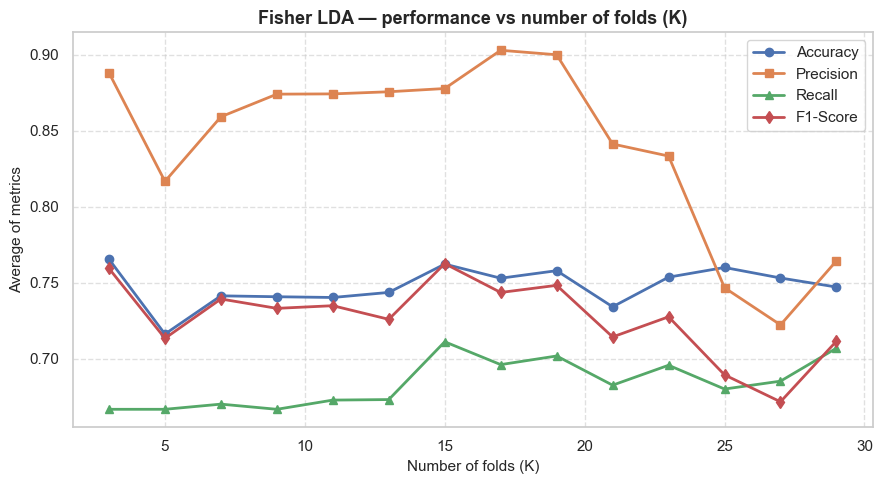

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ---- Dados ----
X_sel = X_train_scaled_df[top_features].to_numpy()
y = y_train.to_numpy()

# Valores ímpares de k entre 3 e 29
k_values = [k for k in range(3, 30, 2)]

classes_all = np.unique(y)
c1, c2 = classes_all[0], classes_all[1]

# Armazenar resultados
k_results = []

# ---- Loop pelos diferentes K ----
for k in k_values:
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
    metrics = []

    for train_index, test_index in skf.split(X_sel, y):
        X_train_fold, X_test_fold = X_sel[train_index], X_sel[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        # Fisher LDA
        cc1, cc2 = np.unique(y_train_fold)
        m1 = X_train_fold[y_train_fold == cc1].mean(axis=0)
        m2 = X_train_fold[y_train_fold == cc2].mean(axis=0)

        Sw = np.zeros((X_train_fold.shape[1], X_train_fold.shape[1]))
        for c, m in ((cc1, m1), (cc2, m2)):
            Xc = X_train_fold[y_train_fold == c] - m
            Sw += Xc.T @ Xc

        w = np.linalg.pinv(Sw) @ (m2 - m1)
        b = -0.5 * (w.T @ (m1 + m2))

        pred_test = np.where((X_test_fold @ w + b) > 0, cc2, cc1)

        acc = accuracy_score(y_test_fold, pred_test)
        prec = precision_score(y_test_fold, pred_test, pos_label=cc2, zero_division=0)
        rec = recall_score(y_test_fold, pred_test, pos_label=cc2, zero_division=0)
        f1 = f1_score(y_test_fold, pred_test, pos_label=cc2, zero_division=0)

        metrics.append([acc, prec, rec, f1])

    metrics = np.array(metrics)
    k_results.append([k] + metrics.mean(axis=0).tolist())

# ---- DataFrame final ----
k_results_df = pd.DataFrame(k_results, columns=["K", "Accuracy", "Precision", "Recall", "F1-Score"])
print("\nAverage results for K:")
print(k_results_df.round(3))

# ---- Plot ----
plt.figure(figsize=(9,5))
plt.plot(k_results_df["K"], k_results_df["Accuracy"], marker='o', label='Accuracy', linewidth=2)
plt.plot(k_results_df["K"], k_results_df["Precision"], marker='s', label='Precision', linewidth=2)
plt.plot(k_results_df["K"], k_results_df["Recall"], marker='^', label='Recall', linewidth=2)
plt.plot(k_results_df["K"], k_results_df["F1-Score"], marker='d', label='F1-Score', linewidth=2)

plt.title("Fisher LDA — performance vs number of folds (K)", fontsize=13, weight='bold')
plt.xlabel("Number of folds (K)", fontsize=11)
plt.ylabel("Average of metrics", fontsize=11)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### k-NN

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score
import numpy as np
import matplotlib.pyplot as plt


X = data.drop(columns=["Classification"])
y = data["Classification"]

# Split (10%)
X_train_full, X_test_final, y_train_full, y_test_final = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

features = ['Glucose', 'HOMA', 'Resistin', 'Insulin', 'Adiponectin', 'Age']
ks = np.arange(1, 30, 2)
n_folds = 15
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

allErrMat = np.zeros((n_folds, len(ks)))

metrics_by_fold = {"Accuracy": [], "Precision": [], "F1": []}

# Função k-NN
def k_NN(ks, X_train, X_val, y_train, y_val, best_features, fold, metrics_dict, isTrain=True):
    X_train = X_train[best_features].to_numpy()
    X_val = X_val[best_features].to_numpy()
    y_train = y_train.to_numpy()
    y_val = y_val.to_numpy()

    # Normalização com base no treino
    muTr = np.mean(X_train, axis=0)
    stdTr = np.std(X_train, axis=0)
    X_train_norm = (X_train - muTr) / stdTr
    X_val_norm = (X_val - muTr) / stdTr

    errMat = np.zeros(len(ks))  # Erro para cada k

    for ki, k in enumerate(ks):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_norm, y_train)
        yp = knn.predict(X_val_norm)

        Acc = np.mean(yp == y_val)
        errMat[ki] = (1 - Acc) * 100

        # Salvar métricas para teste final
        if fold < 0:
            metrics_dict["Accuracy"].append(accuracy_score(y_val, yp))
            metrics_dict["Precision"].append(precision_score(y_val, yp, zero_division=0))
            metrics_dict["F1"].append(f1_score(y_val, yp, zero_division=0))

    # Salvar no allErrMat somente se for validação
    if fold >= 0:
        allErrMat[fold, :] = errMat

    # Encontrar o melhor k
    optK = ks[np.argmin(errMat)]

    if isTrain:
        knn = KNeighborsClassifier(n_neighbors=optK)
        knn.fit(X_train_norm, y_train)
        yp = knn.predict(X_val_norm)
        Acc = np.mean(yp == y_val)
        Err = (1 - Acc) * 100
        print(f"Best k = {optK}, Error (%) = {Err}\n")

    # Salvar métricas por fold (para validação)
    if fold >= 0:
        metrics_dict["Accuracy"].append(accuracy_score(y_val, yp))
        metrics_dict["Precision"].append(precision_score(y_val, yp, zero_division=0))
        metrics_dict["F1"].append(f1_score(y_val, yp, zero_division=0))



for fold, (train_index, val_index) in enumerate(skf.split(X_train_full, y_train_full)):
    X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]

    print(f"Fold {fold+1}")
    print("TRAIN:", X_train.shape, y_train.shape)
    print("VAL:", X_val.shape, y_val.shape)

    k_NN(ks, X_train, X_val, y_train, y_val, features, fold, metrics_by_fold)

# Melhor k médio dos folds
mean_k = np.mean(allErrMat, axis=0)
best_k = ks[np.argmin(mean_k)]
print(f"Melhor k médio dos folds: {best_k}\n")

# Plot métricas por fold
plt.figure(figsize=(12,6))
K_vals = np.arange(1, n_folds + 1)
plt.plot(K_vals, metrics_by_fold["Accuracy"], marker='o', label="Accuracy")
plt.plot(K_vals, metrics_by_fold["Precision"], marker='s', label="Precision")
plt.plot(K_vals, metrics_by_fold["F1"], marker='d', label="F1-Score")
plt.title("k-NN — Performance vs Número de Folds (melhor k por fold)")
plt.xlabel("Fold")
plt.ylabel("Métrica")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


# Teste
metrics_for_test = {"Accuracy": [], "Precision": [], "F1": []}

for k in ks:
    k_NN([k], X_train_full, X_test_final, y_train_full, y_test_final, features, fold=-1, metrics_dict=metrics_for_test, isTrain=False)

# Plot métricas vs ks no teste final
plt.figure(figsize=(12,6))
plt.plot(ks, metrics_for_test["Accuracy"], marker='o', label="Accuracy")
plt.plot(ks, metrics_for_test["Precision"], marker='s', label="Precision")
plt.plot(ks, metrics_for_test["F1"], marker='d', label="F1-Score")
plt.title("k-NN — Performance vs ks no conjunto de teste")
plt.xlabel("Número de vizinhos (k)")
plt.ylabel("Métrica")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Treino final e cálculo de erro
X_train_full_np = X_train_full[features].to_numpy()
X_test_final_np = X_test_final[features].to_numpy()

muTr_full = np.mean(X_train_full_np, axis=0)
stdTr_full = np.std(X_train_full_np, axis=0)

X_train_full_norm = (X_train_full_np - muTr_full) / stdTr_full
X_test_final_norm = (X_test_final_np - muTr_full) / stdTr_full

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_full_norm, y_train_full)

yp = knn.predict(X_test_final_norm)

Hits = (np.where(yp == y_test_final)[0]).shape[0]
Acc = Hits / y_test_final.shape[0]
Err = (1 - Acc) * 100

print(f"Error final no teste (%) = {Err}")